In [384]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.ticker as mtick
import math
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

In [276]:
data = pd.read_csv(r'ex_data.csv')

In [277]:
data_train = data[:-62]
data_test = data[-62:]

In [278]:
data_train.head()

,A,B,C,D,E,F,G,H,I,J,K,L,FORECAST
0,0.006193,0.999981,0.074248,0.997240,-2.390000e-12,1,2789200,2.0,5110000,60368.10849,6830.664682,6001.226828,73200
1,0.023394,0.999726,0.277076,0.960848,-1.260000e-11,1,2676700,1.9,5110000,95237.30078,8637.150935,8625.548282,112500
2,0.040587,0.999176,0.468138,0.883655,-8.340000e-12,1,2504600,0.8,5110000,145585.58850,13118.714220,13395.697320,172100
3,0.057769,0.998330,0.639322,0.768939,-4.050000e-12,1,2401600,0.7,5110000,89166.80345,7036.073449,6797.123097,103000
4,0.074934,0.997189,0.783358,0.621571,2.520000e-13,1,2038000,0.6,5110000,297611.59020,35363.573650,30624.836150,363600


In [279]:
data_test.head()

,A,B,C,D,E,F,G,H,I,J,K,L,FORECAST
1017,-0.975314,0.220822,0.452619,-0.891704,-1.090000e-11,1,979000,0.0,3320000,48979.69536,4413.559288,4506.745350,57900
1018,-0.971371,0.237567,0.260236,-0.965545,-6.600000e-12,1,3612600,0.0,3720000,108212.14010,8538.924089,8248.935798,125000
1019,-0.967141,0.254241,0.056803,-0.998385,-2.310000e-12,1,3035100,0.0,3720000,472691.67590,56167.392140,48640.932000,577500
1020,-0.962624,0.270840,-0.149042,-0.988831,-1.260000e-11,1,2515100,0.0,3720000,427455.51270,53562.115360,38982.371960,520000
1021,-0.957823,0.287359,-0.348559,-0.937287,-8.260000e-12,1,2123800,0.0,3720000,320516.42820,38427.889540,32355.682270,391300


# Prepare Data

In [280]:
def make_Xy(data, n_input, n_out) :
    data = data.values
    X, y = list(), list()
    in_start = 0
    for _ in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end <= len(data):
            x_input = data[in_start:in_end, : ]
            x_input = x_input.reshape((len(x_input), -1))
            X.append(x_input)
            y.append(data[in_end:out_end, : ])
        in_start += 1
    X = np.array(X)
    y = np.array(y)[ : , : , -1:]
    return X, y

In [281]:
X , y = make_Xy(data_train,31,1) 

In [282]:
X.shape, y.shape

((986, 31, 13), (986, 1, 1))

# Scale value between 0 - 1
## By MIN-MAX method

In [283]:
def min_max_scale(data, scalers={}, inv=False):
    if(len(scalers)==0) :
        for i in range(data.shape[2]):
            scalers[i] = MinMaxScaler(feature_range=(0, 1))
            scalers[i].fit_transform(data[:, :, i])
            data[:, :, i] = scalers[i].transform(data[:, :, i])
        return data, scalers
    else :
        for i in range(data.shape[2]):
            if inv :
                data[:, :, i] = scalers[i].inverse_transform(data[:, :, i])
            else :
                data[:, :, i] = scalers[i].transform(data[:, :, i])
        return data

In [284]:
(X_sc, scale_X) = min_max_scale(X.copy(), {})
(y_sc, scale_y) = min_max_scale(y.copy(), {})

In [285]:
tscv = TimeSeriesSplit(n_splits=2)
for train_index, validate_index in tscv.split(X_sc):
     (X_train, X_validate, y_train, y_validate) = (X_sc[train_index], X_sc[validate_index], y_sc[train_index], y_sc[validate_index])

In [286]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, min_delta=0.0001, restore_best_weights=True)


# Create Model
1. Only CNN
2. Only GRU
3. Combine CNN with GRU

## 1. Only CNN

In [261]:
def CNN_model( timesteps, feature ) :
    input = Input(shape=(timesteps, feature))
    conv11 = Conv1D(64 ,kernel_size=2, padding = "same", activation='relu' )(input)
    pool11 =  MaxPooling1D(strides = 1)(conv11)
    conv21 = Conv1D(64 ,kernel_size=2, padding = "same", activation='relu')(pool11)
    pool12 =  MaxPooling1D(strides = 1)(conv21)
    flat11 = Flatten()(pool12)
    fully = Dense(256,activation='relu', name="fully")(flat11)
    output = Dense(1, activation='relu')(fully)
    model = Model(inputs=input, outputs=output)
    return model

In [262]:
cnn = CNN_model(31, 13)
cnn.compile(optimizer='Adam', loss= 'mse')
cnn.summary()

Model: "functional_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 31, 13)]          0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 31, 64)            1728      
_________________________________________________________________
max_pooling1d_54 (MaxPooling (None, 30, 64)            0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 30, 64)            8256      
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 29, 64)            0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 1856)              0         
_________________________________________________________________
fully (Dense)                (None, 256)             

In [47]:
history_cnn = cnn.fit(X_train, y_train, 64, 200, validation_data=(X_validate, y_validate), callbacks=[es], shuffle=False)

Epoch 1/200
11/11 [==============================] - 1s 68ms/step - loss: 4.0159 - val_loss: 2.9615
Epoch 2/200
11/11 [==============================] - 0s 30ms/step - loss: 2.4523 - val_loss: 1.9051
Epoch 3/200
11/11 [==============================] - 0s 28ms/step - loss: 1.5969 - val_loss: 1.2908
Epoch 4/200
11/11 [==============================] - 0s 29ms/step - loss: 1.1128 - val_loss: 0.9534
Epoch 5/200
11/11 [==============================] - 0s 28ms/step - loss: 0.8471 - val_loss: 0.7649
Epoch 6/200
11/11 [==============================] - 0s 28ms/step - loss: 0.6939 - val_loss: 0.6489
Epoch 7/200
11/11 [==============================] - 0s 28ms/step - loss: 0.5946 - val_loss: 0.5675
Epoch 8/200
11/11 [==============================] - 0s 28ms/step - loss: 0.5217 - val_loss: 0.5042
Epoch 9/200
11/11 [==============================] - 0s 29ms/step - loss: 0.4635 - val_loss: 0.4522
Epoch 10/200
11/11 [==============================] - 0s 28ms/step - loss: 0.4152 - val_loss: 0.4085

## 2. Only GRU

In [311]:
def GRU_model( timesteps, feature ) :
    input = Input(shape=(timesteps, feature))
    flat11 = TimeDistributed(Flatten(),name=f"flat11")(input)
    gru = GRU(256, activation="relu")(flat11)
    fully = Dense(256, kernel_regularizer='l2', activation='relu', name="fully")(gru)
    output = Dense(1, activation='relu')(fully)
    model = Model(inputs=input, outputs=output)
    return model

In [312]:
gru = GRU_model(31, 13)
gru.compile(optimizer='Adam', loss= 'mse')
gru.summary()

Model: "functional_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 31, 13)]          0         
_________________________________________________________________
flat11 (TimeDistributed)     (None, 31, 13)            0         
_________________________________________________________________
gru_7 (GRU)                  (None, 256)               208128    
_________________________________________________________________
fully (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 257       
Total params: 274,177
Trainable params: 274,177
Non-trainable params: 0
_________________________________________________________________


In [50]:
history_gru = gru.fit(X_train, y_train, 64, 200, validation_data=(X_validate, y_validate), callbacks=[es], shuffle=False)

Epoch 1/200
16/16 [==============================] - 0s 14ms/step - loss: 0.2580 - val_loss: 0.2306
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.2053 - val_loss: 0.1874
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.1667 - val_loss: 0.1526
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.1368 - val_loss: 0.1252
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.1134 - val_loss: 0.1046
Epoch 6/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0952 - val_loss: 0.0893
Epoch 7/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0814 - val_loss: 0.0777
Epoch 8/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0710 - val_loss: 0.0689
Epoch 9/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0630 - val_loss: 0.0620
Epoch 10/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0568 - val_loss: 0.0564
Epoch 11

## 3. Combine CNN with GRU

In [254]:
def model( timesteps, feature ) :
    input = Input(shape=(timesteps, feature))
    conv11 = Conv1D(64 ,kernel_size=2, padding = "same", activation='relu' )(input)
    pool11 =  MaxPooling1D(strides = 1)(conv11)
    conv21 = Conv1D(64 ,kernel_size=2, padding = "same", activation='relu')(pool11)
    pool12 =  MaxPooling1D(strides = 1)(conv21)
    flat11 = TimeDistributed(Flatten(),name=f"flat11")(pool12)
    gru = GRU(256, activation="relu")(flat11)
    fully = Dense(256, kernel_regularizer='l2', activation='relu', name="fully")(gru)
    output = Dense(1, activation='relu')(fully)
    model = Model(inputs=input, outputs=output)
    return model

In [255]:
cb_model = model(31, 13)
cb_model.compile(optimizer='Adam', loss= 'mse')
cb_model.summary()

Model: "functional_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 31, 13)]          0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 31, 64)            1728      
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 30, 64)            0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 30, 64)            8256      
_________________________________________________________________
max_pooling1d_53 (MaxPooling (None, 29, 64)            0         
_________________________________________________________________
flat11 (TimeDistributed)     (None, 29, 64)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 256)             

In [53]:
history_cb = cb_model.fit(X_train, y_train, 64, 200, validation_data=(X_validate, y_validate), callbacks=[es], shuffle=False)

Epoch 1/200
16/16 [==============================] - 3s 168ms/step - loss: 2.1453 - val_loss: 1.6585
Epoch 2/200
16/16 [==============================] - 2s 137ms/step - loss: 1.3397 - val_loss: 1.0104
Epoch 3/200
16/16 [==============================] - 2s 137ms/step - loss: 0.8064 - val_loss: 0.5984
Epoch 4/200
16/16 [==============================] - 2s 132ms/step - loss: 0.4715 - val_loss: 0.3478
Epoch 5/200
16/16 [==============================] - 2s 132ms/step - loss: 0.2716 - val_loss: 0.2008
Epoch 6/200
16/16 [==============================] - 2s 133ms/step - loss: 0.1569 - val_loss: 0.1176
Epoch 7/200
16/16 [==============================] - 2s 134ms/step - loss: 0.0932 - val_loss: 0.0715
Epoch 8/200
16/16 [==============================] - 2s 131ms/step - loss: 0.0583 - val_loss: 0.0471
Epoch 9/200
16/16 [==============================] - 2s 131ms/step - loss: 0.0397 - val_loss: 0.0345
Epoch 10/200
16/16 [==============================] - 2s 132ms/step - loss: 0.0302 - val_lo

# Plot compare result

In [54]:
number_epoch = [len(history_cnn.history['loss']), len(history_gru.history['loss']), len(history_cb.history['loss'])]

In [453]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', size=16)


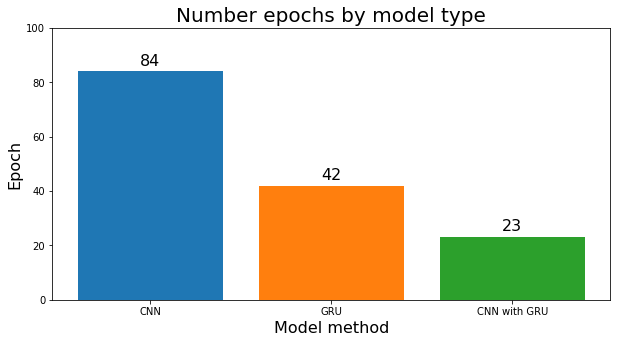

In [454]:
fig, ax = plt.subplots(figsize=(10,5))
a = ax.bar('CNN',number_epoch[0])
b = ax.bar('GRU',number_epoch[1])
c = ax.bar('CNN with GRU',number_epoch[2])

ax.set_ylabel('Epoch', size=16)
ax.set_title('Number epochs by model type', size=20)
ax.set_ylim(0,100)
ax.set_xlabel("Model method", size=16)

autolabel(a,ax)
autolabel(b,ax)
autolabel(c,ax)

# Loss values

In [57]:
merg_loss = [history_cnn.history, history_gru.history, history_cb.history]

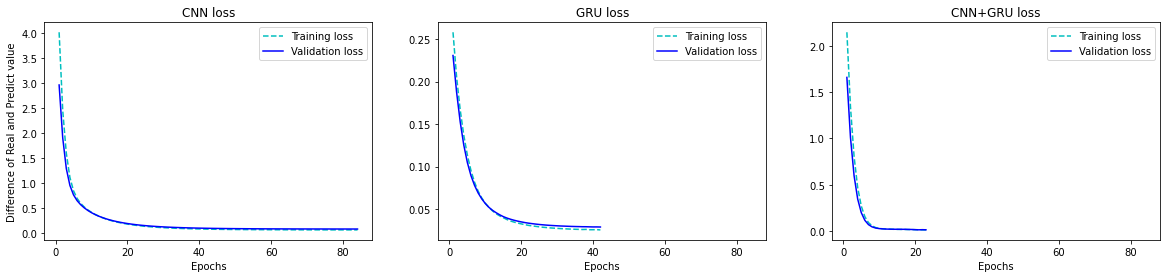

In [58]:
fig, axs = plt.subplots(1,3,figsize=(20,4), sharex=True)
CNN_loss_plot, GRU_loss_plot, Hybrid_loss_plot = axs
CNN_loss_plot.plot(range(1,number_epoch[0]+1), merg_loss[0]['loss'], 'c--', label='Training loss')
CNN_loss_plot.plot(range(1,number_epoch[0]+1), merg_loss[0]['val_loss'], 'b', label='Validation loss')
CNN_loss_plot.set_title('CNN loss')
CNN_loss_plot.set_xlabel('Epochs')
CNN_loss_plot.set_ylabel('Difference of Real and Predict value')
CNN_loss_plot.legend()

GRU_loss_plot.plot(range(1,number_epoch[1]+1), merg_loss[1]['loss'], 'c--', label='Training loss')
GRU_loss_plot.plot(range(1,number_epoch[1]+1), merg_loss[1]['val_loss'], 'b', label='Validation loss')
GRU_loss_plot.set_title('GRU loss')
GRU_loss_plot.set_xlabel('Epochs')
GRU_loss_plot.legend()

Hybrid_loss_plot.plot(range(1,number_epoch[2]+1), merg_loss[2]['loss'], 'c--', label='Training loss')
Hybrid_loss_plot.plot(range(1,number_epoch[2]+1), merg_loss[2]['val_loss'], 'b', label='Validation loss')
Hybrid_loss_plot.set_title('CNN+GRU loss')
Hybrid_loss_plot.set_xlabel('Epochs')
Hybrid_loss_plot.legend()

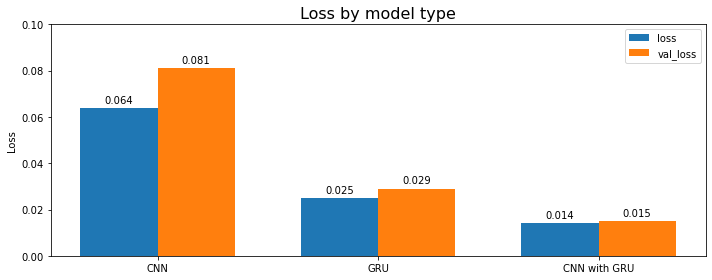

In [452]:
labels = ['CNN', 'GRU', 'CNN with GRU']
loss = [min(loss['loss']) for loss in merg_loss]
val_loss = [min(loss['val_loss']) for loss in merg_loss]

x = np.arange(len(labels))
width = 0.35 

fig, ax = plt.subplots(figsize=(10,4))
rects1 = ax.bar(x - width/2, loss, width, label='loss')
rects2 = ax.bar(x + width/2, val_loss, width, label='val_loss')

ax.set_ylabel('Loss')
ax.set_title('Loss by model type', size=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0,0.1)

def autolabels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabels(rects1)
autolabels(rects2)

fig.tight_layout()

plt.show()

# Prediction

In [355]:
X_test , y_test = make_Xy(data_test,31,1) 

In [356]:
(X_test_sc, scale_X_test) = min_max_scale(X_test.copy(), {})
(y_test_sc, scale_y_test) = min_max_scale(y_test.copy(), {})

In [369]:
cnn_output = scale_y_test[0].inverse_transform(cnn.predict(X_test_sc)).reshape(-1)

In [370]:
gru_output = scale_y_test[0].inverse_transform(gru.predict(X_test_sc)).reshape(-1)

In [371]:
cb_output = scale_y_test[0].inverse_transform(cb_model.predict(X_test_sc)).reshape(-1)

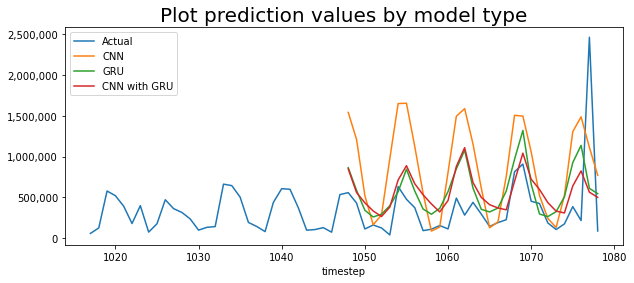

In [451]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(data_test['FORECAST'], label="Actual")
ax.plot(data_test.index[-31:],cnn_output, label="CNN")
ax.plot(data_test.index[-31:],gru_output, label="GRU")
ax.plot(data_test.index[-31:],cb_output, label="CNN with GRU")
ax.set_title('Plot prediction values by model type', size=20)
ax.set_xlabel("timestep")
ax.legend()
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

In [420]:
error_cnn = np.mean([math.sqrt(x) for x in pow((cnn_output - data_test['FORECAST'].values[-31:]),2)])
error_gru = np.mean([math.sqrt(x) for x in pow((gru_output - data_test['FORECAST'].values[-31:]),2)])
error_cb = np.mean([math.sqrt(x) for x in pow((cb_output - data_test['FORECAST'].values[-31:]),2)])

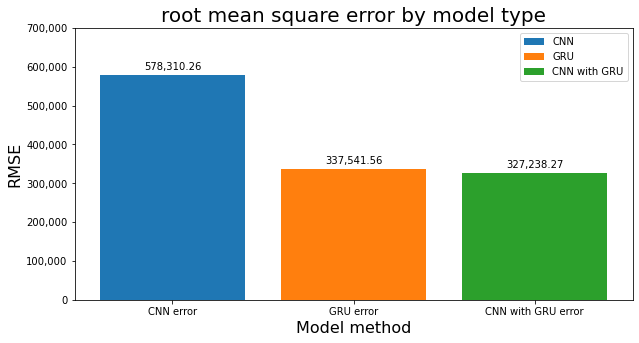

In [450]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:,.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

fig, ax = plt.subplots(figsize=(10,5))
a = ax.bar('CNN error',error_cnn, label="CNN")
b = ax.bar('GRU error',error_gru, label="GRU")
c = ax.bar('CNN with GRU error',error_cb, label="CNN with GRU")

ax.set_ylabel('RMSE', size=16)
ax.set_title('root mean square error by model type', size=20)
ax.set_ylim(0,700000)
ax.set_xlabel("Model method", size=16)

autolabel(a,ax)
autolabel(b,ax)
autolabel(c,ax)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.legend()